In [1]:
import pandas as pd
import scipy
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.linear_model import LinearRegression
plt.style.use('ggplot')
import datetime

import matplotlib.colors as colors
from pandas.plotting import parallel_coordinates
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Weather_Data.csv")

In [3]:
date_start = datetime.datetime.strptime(df['Date'][0], '%d-%m-%y')
date_end = datetime.datetime.strptime(df['Date'][df.index.stop - 1], '%d-%m-%y')
delta = date_end - date_start
if delta.days == df.index.stop - 1:
    print(f"OK. We have all days' data from {str(date_start)} to {str(date_end)}.")

OK. We have all days' data from 2013-02-01 00:00:00 to 2022-01-15 00:00:00.


In [5]:
df.drop(columns=['Date'], inplace=True)

In [6]:
df['IsTodayRainy'] = df.apply(lambda x: 1 if x['RainToday'] == "Yes" else 0, axis=1)

In [7]:
df.drop(columns=['RainToday'], inplace=True)

In [8]:
def interpret_wind_str(wind_dir):
    winds = {'N': 0, 'S': 0, 'W': 0, 'E': 0}
    for letter in wind_dir:
        winds[letter] += 1
    max_value = 0
    for value in winds.values():
        max_value = max_value if value < max_value else value
    return (winds['N'] / max_value, winds['S'] / max_value, winds['W'] / max_value, winds['E'] / max_value)

def separate_wind_dirs(df, wind_dir_col_key):
    wind_dirs = [interpret_wind_str(df[wind_dir_col_key][i]) for i in range(df.index.stop)]
    dir_strs = ['_north', '_south', '_west', '_east']
    for i, dir_str in enumerate(dir_strs):
        winds = [wind_dir[i] for wind_dir in wind_dirs]
        df[wind_dir_col_key + dir_str] = winds
    df.drop(columns=[wind_dir_col_key], inplace=True)

wind_dir_col_keys = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

for wind_dir_col_key in wind_dir_col_keys:
    separate_wind_dirs(df, wind_dir_col_key)


In [9]:
# max(df['Temp9am'])
df.columns

Index(['Temp9am', 'Temp3pm', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'IsTodayRainy', 'WindGustDir_north', 'WindGustDir_south',
       'WindGustDir_west', 'WindGustDir_east', 'WindDir9am_north',
       'WindDir9am_south', 'WindDir9am_west', 'WindDir9am_east',
       'WindDir3pm_north', 'WindDir3pm_south', 'WindDir3pm_west',
       'WindDir3pm_east'],
      dtype='object')

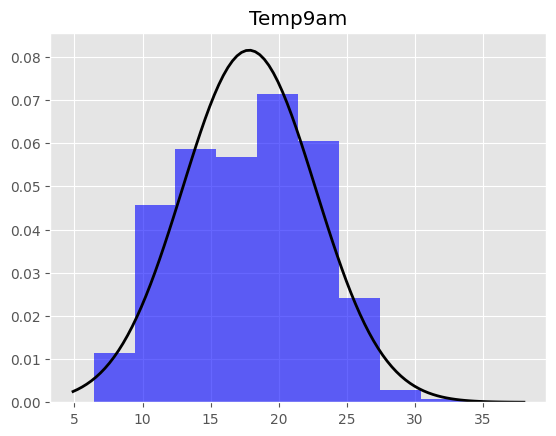

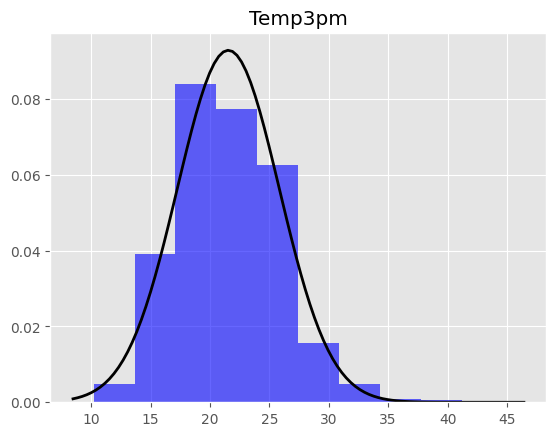

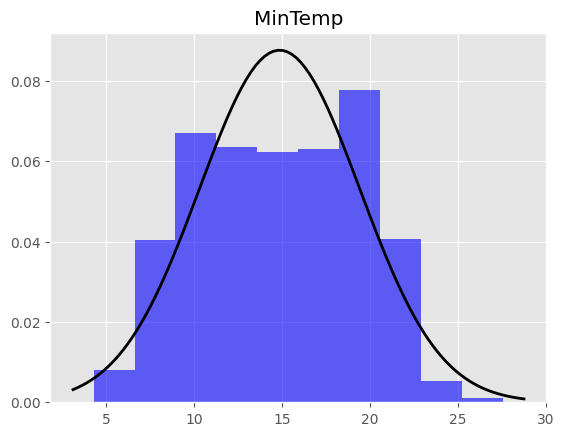

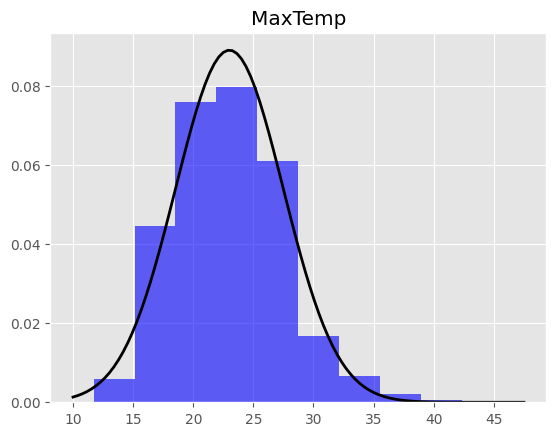

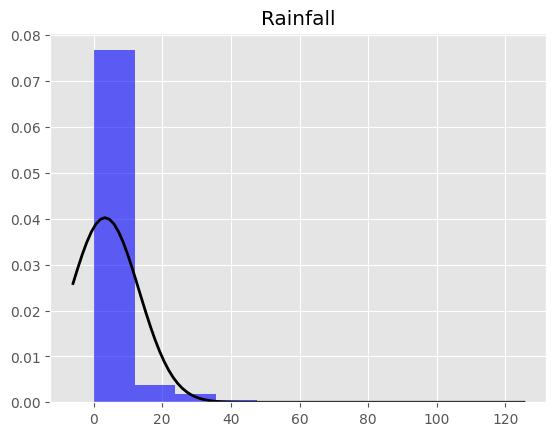

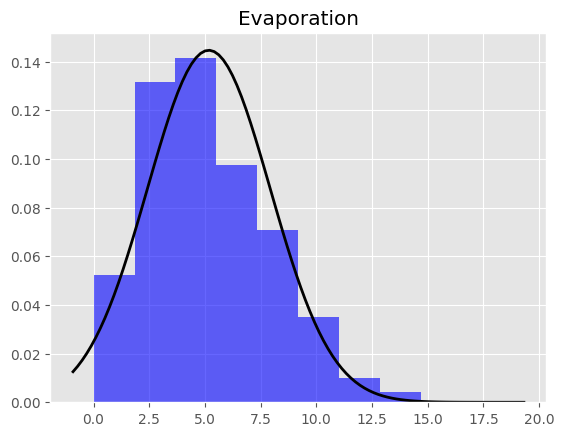

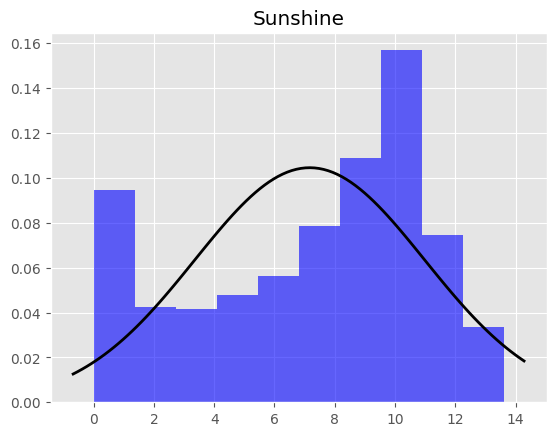

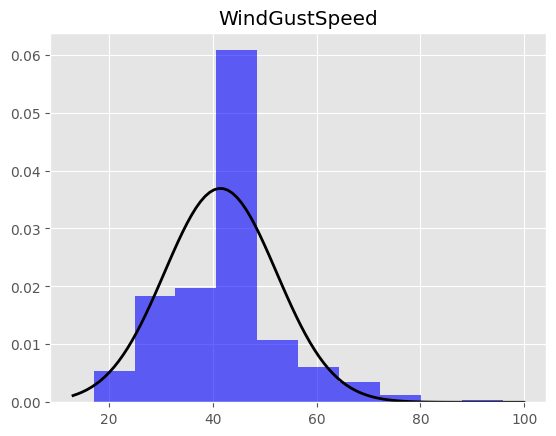

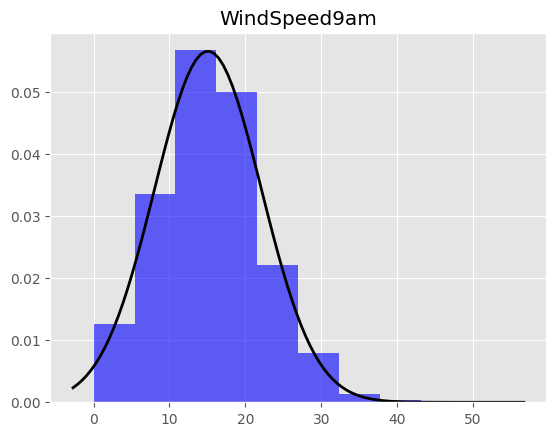

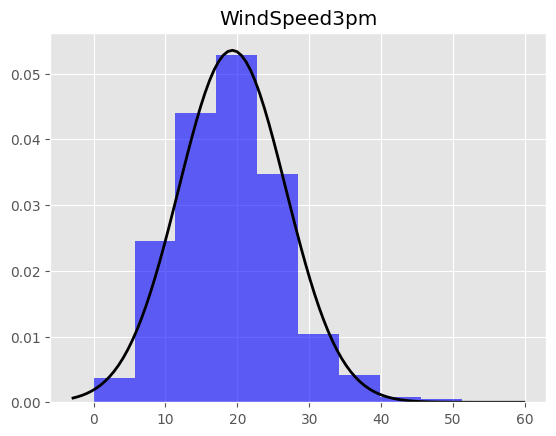

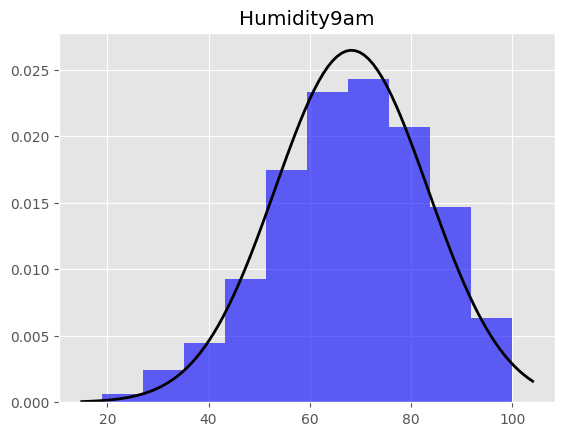

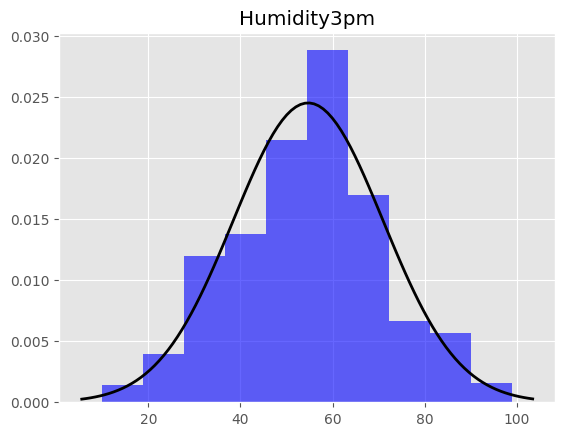

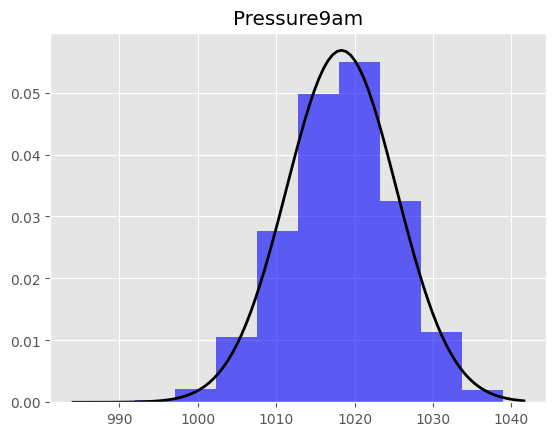

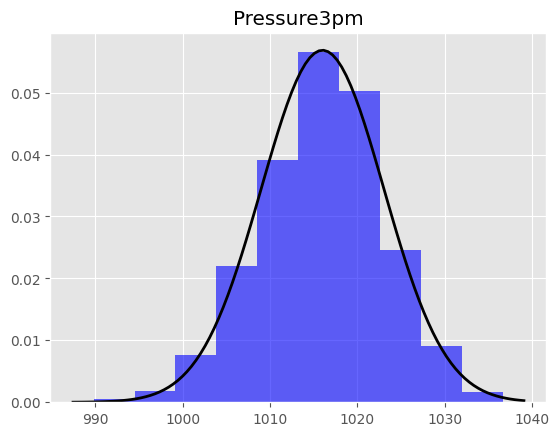

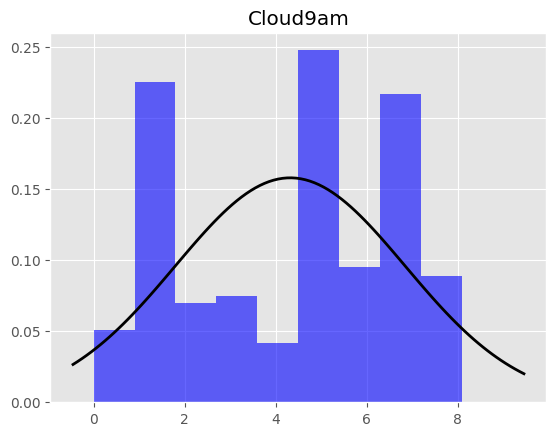

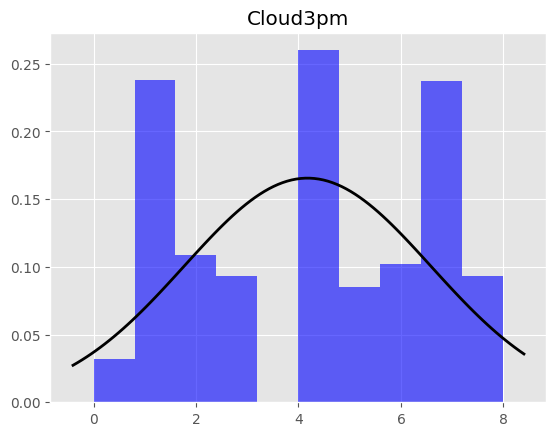

In [10]:
attributes = ['Temp9am', 'Temp3pm', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed',
             'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
             'Cloud9am', 'Cloud3pm']
for attr in attributes:
    # Fit a normal distribution to the data:
    # mean and standard deviation
    mu, std = norm.fit(df[attr])
    # Plot the histogram
    plt.hist(df[attr], bins=10, density=True, alpha=0.6, color='b')
    # Plot density function over histogram
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(attr)
    plt.show()

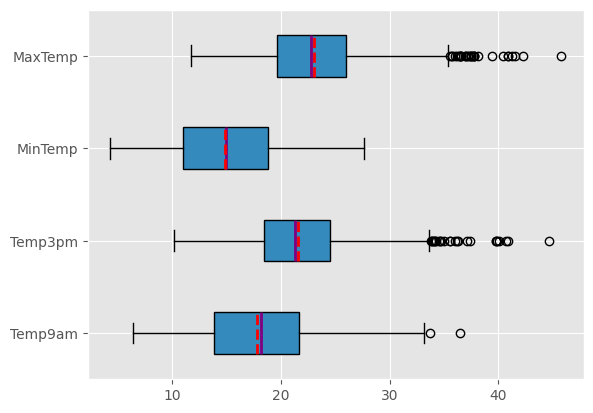

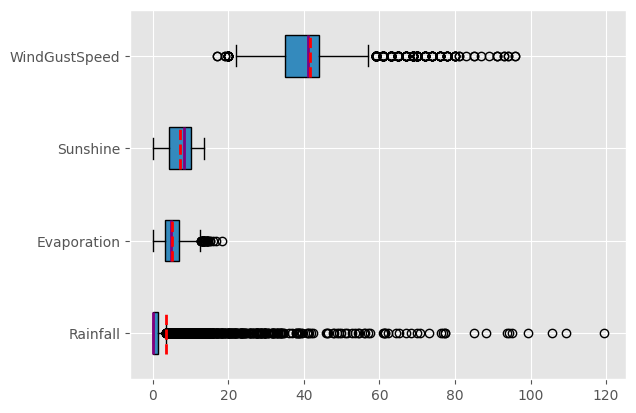

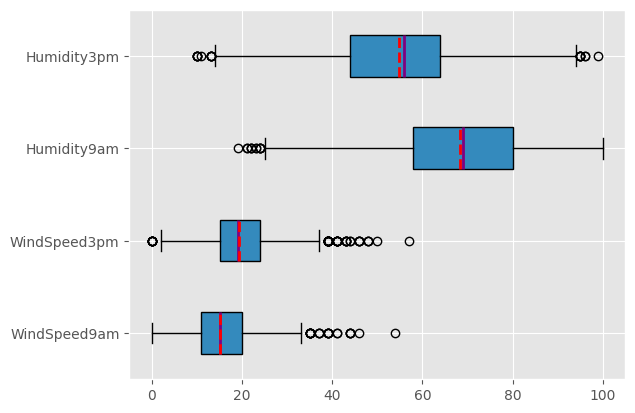

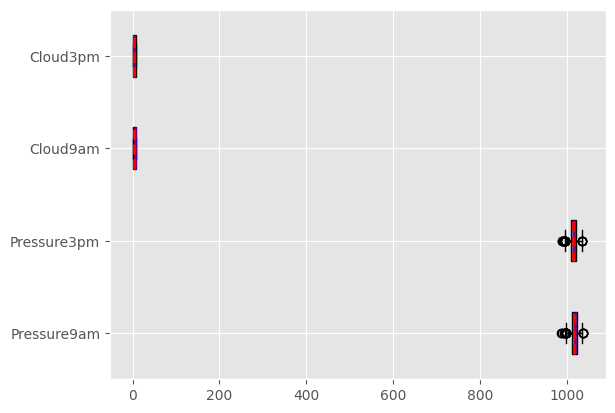

In [17]:
df_cols = [df[attribute] for attribute in attributes]

batch_size = 4
for i in range(0, len(df_cols), batch_size):
    fig, ax = plt.subplots()
    ax.boxplot(df_cols[i:i+min(batch_size,len(df_cols))], vert=False, showmeans=True, meanline=True,
           labels= attributes[i:i+min(batch_size,len(df_cols))], patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
    plt.show()

In [20]:
attributes_full = attributes + ['IsTodayRainy', 'WindGustDir_north', 'WindGustDir_south',
       'WindGustDir_west', 'WindGustDir_east', 'WindDir9am_north',
       'WindDir9am_south', 'WindDir9am_west', 'WindDir9am_east',
       'WindDir3pm_north', 'WindDir3pm_south', 'WindDir3pm_west',
       'WindDir3pm_east']

for i in range(len(attributes_full)):
    for j in range(i+1, len(attributes_full)):
        cov_xy = df[attributes_full[i]].cov(df[attributes_full[j]])
        print(f"Covariance of {attributes_full[i]} and {attributes_full[j]}:"
              f"{cov_xy}")
        r, p = scipy.stats.pearsonr(df[attributes_full[i]], df[attributes_full[j]])
        print(f"Correlation of {attributes_full[i]} and {attributes_full[j]}:"
              f"r = {r}, p-value = {p}")

Covariance of Temp9am and Temp3pm:17.42338389068236
Correlation of Temp9am and Temp3pm:r = 0.8284567143007004, p-value = 0.0
Covariance of Temp9am and MinTemp:20.939222462806786
Correlation of Temp9am and MinTemp:r = 0.9393074869503738, p-value = 0.0
Covariance of Temp9am and MaxTemp:18.842749053165754
Correlation of Temp9am and MaxTemp:r = 0.8586390501545579, p-value = 0.0
Covariance of Temp9am and Rainfall:-2.6356206473906068
Correlation of Temp9am and Rainfall:r = -0.05429725883396037, p-value = 0.001893103897977634
Covariance of Temp9am and Evaporation:8.180810317150906
Correlation of Temp9am and Evaporation:r = 0.6061217199381509, p-value = 0.0
Covariance of Temp9am and Sunshine:2.127085114578397
Correlation of Temp9am and Sunshine:r = 0.11389072939195666, p-value = 6.468580365755985e-11
Covariance of Temp9am and WindGustSpeed:8.44008050545195
Correlation of Temp9am and WindGustSpeed:r = 0.15957006156521147, p-value = 4.245897971617732e-20
Covariance of Temp9am and WindSpeed9am:-1

In [6]:
max(df['MaxTemp'])

45.8

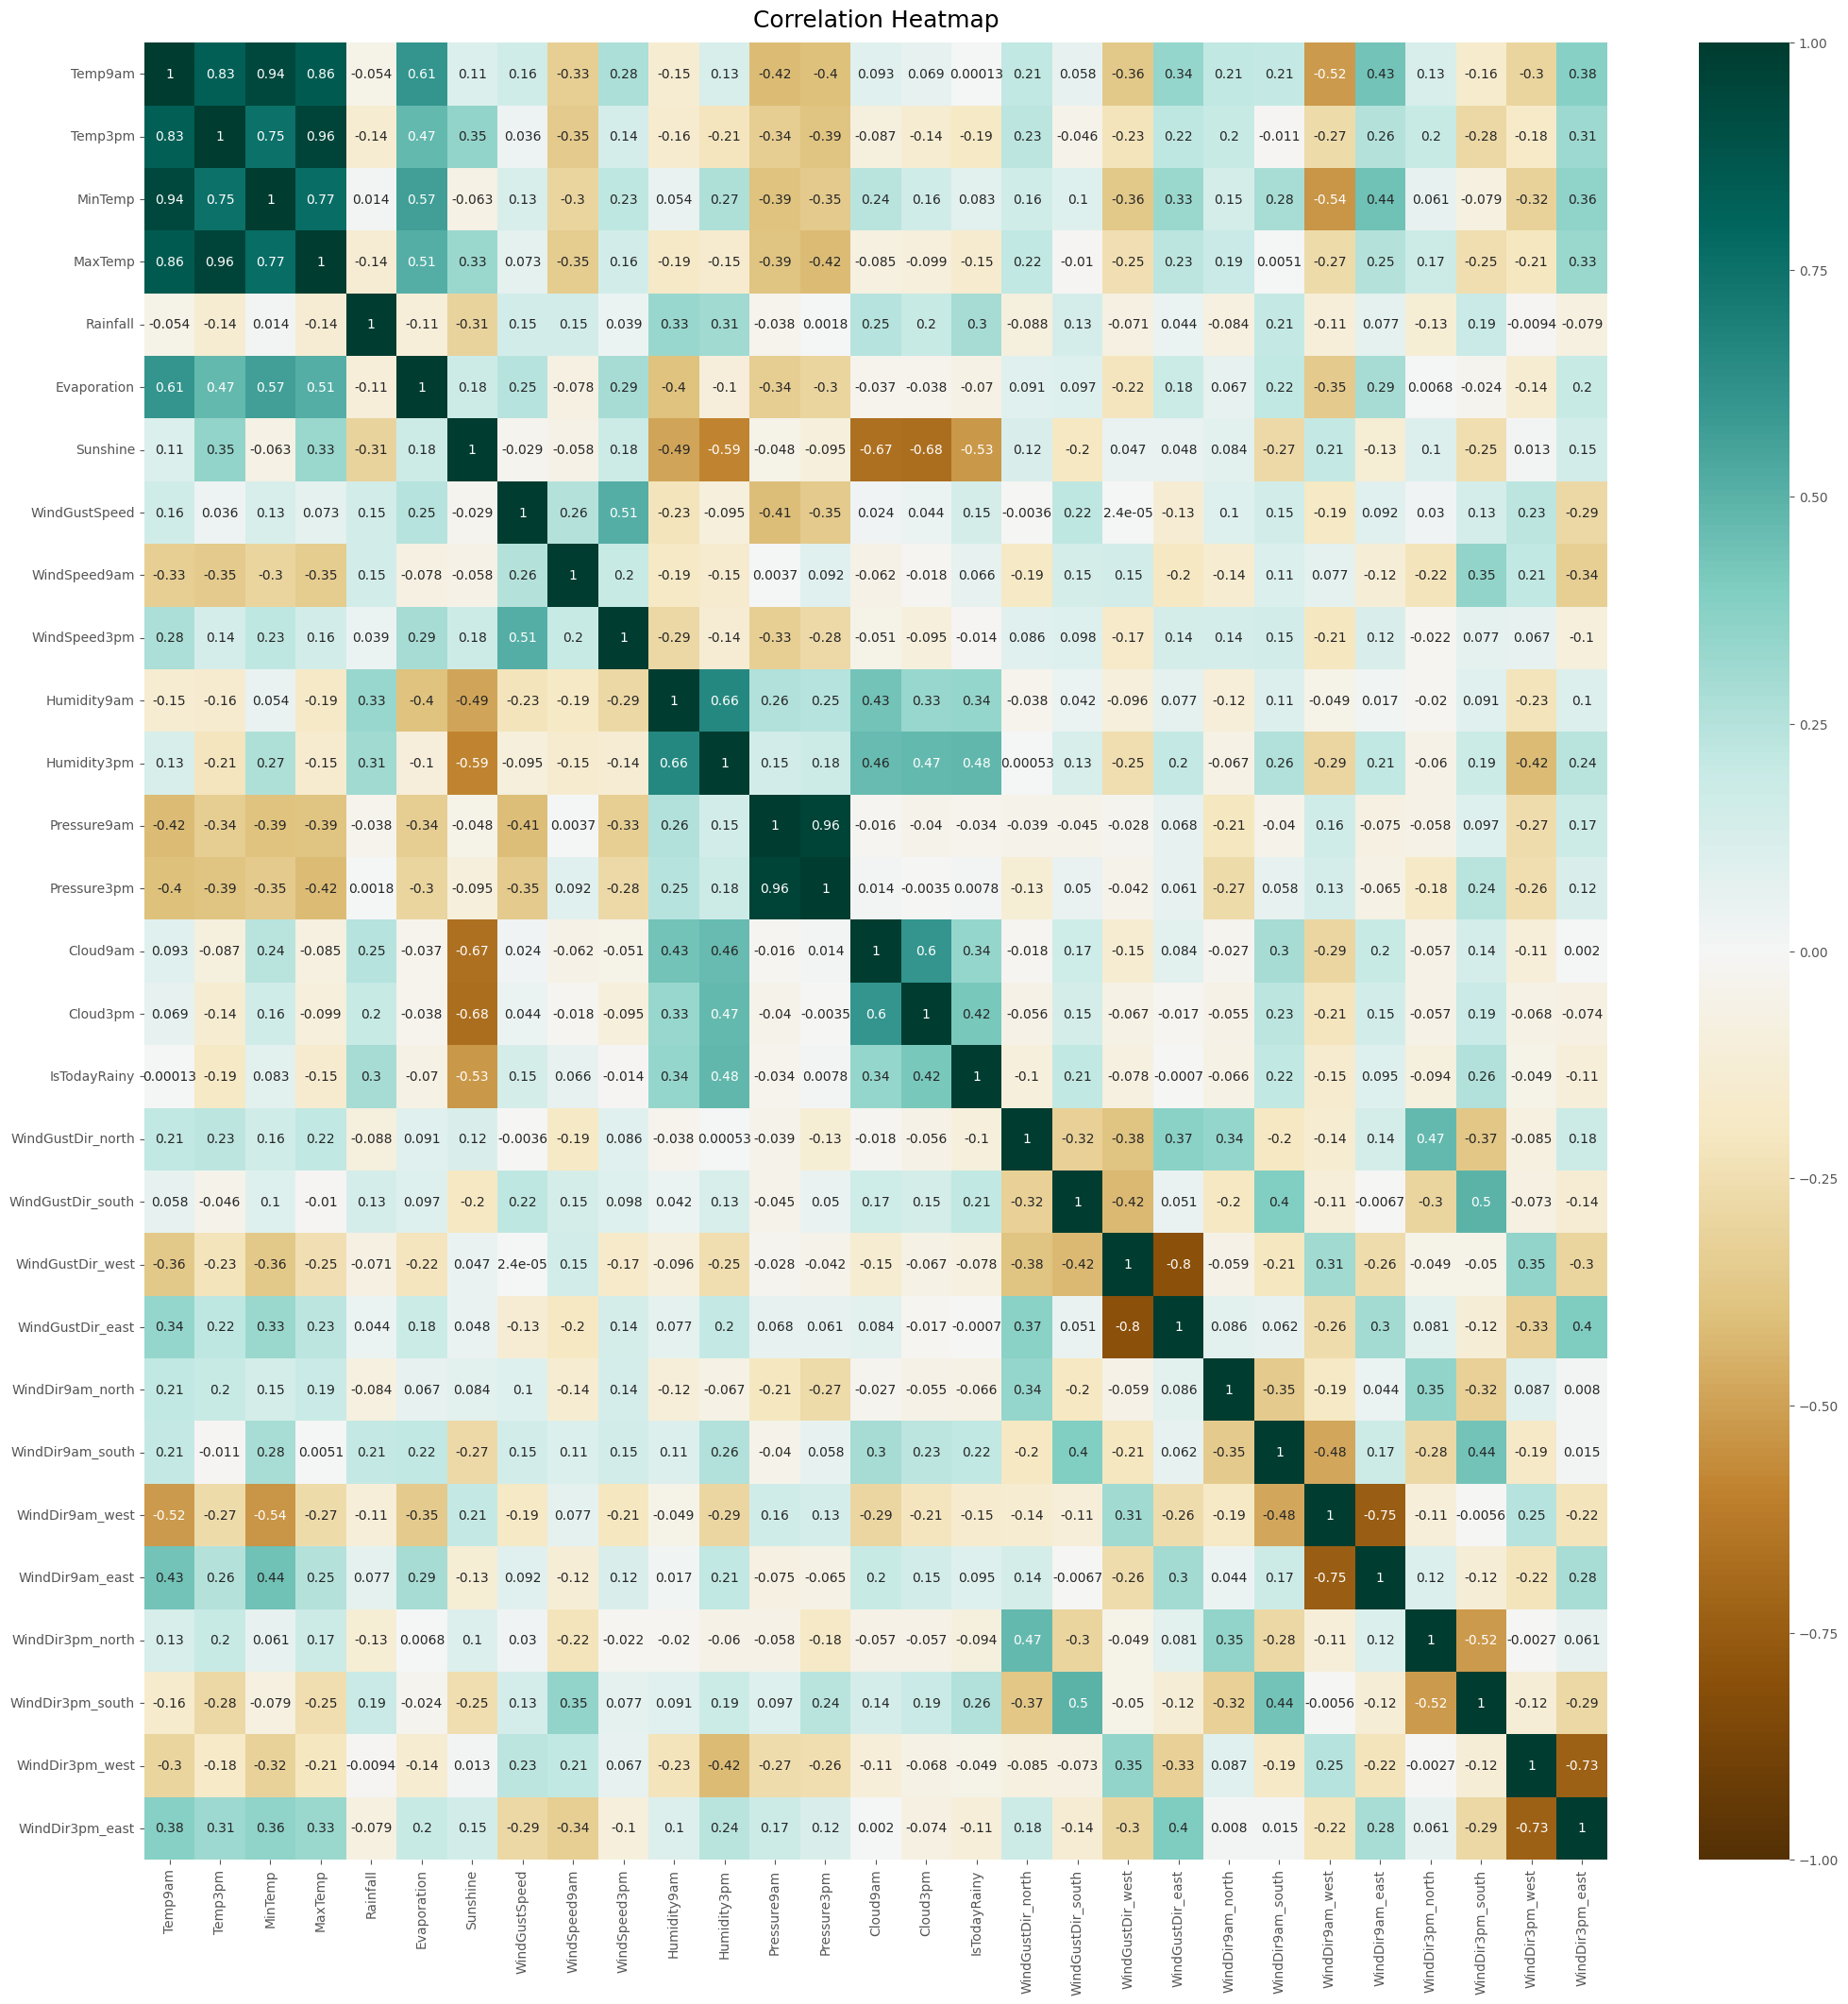

In [26]:
fig, heatmap = plt.subplots(figsize=(25,25))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

In [28]:
weather_crosstab = pd.crosstab(index=df["IsTodayRainy"], columns="count")
print(weather_crosstab)

col_0         count
IsTodayRainy       
0              2422
1               849


In [39]:
df_x = df.drop(columns=['IsTodayRainy'], inplace=False)

In [44]:
#Feature selection
X = df_x.iloc[:,:].values
y = df.iloc[:,16].values

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [45]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
accuracy_nb=round(metrics.accuracy_score(y_test,Y_pred)* 100, 2)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)

Confusion matrix for Naive Bayes
 [[619 105]
 [ 82 176]]
accuracy_Naive Bayes: 0.810
precision_Naive Bayes: 0.810
recall_Naive Bayes: 0.810
f1-score_Naive Bayes : 0.810


<Axes: >

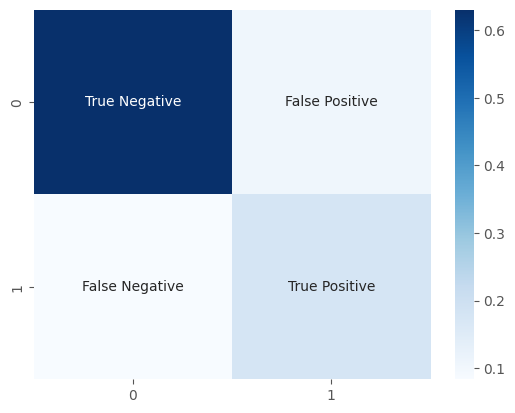

In [52]:
cm = metrics.confusion_matrix(y_test, Y_pred)
accuracy = metrics.accuracy_score(y_test,Y_pred)
precision = metrics.precision_score(y_test, Y_pred,average='micro')
recall = metrics.recall_score(y_test, Y_pred,average='micro')
f1 = metrics.f1_score(y_test,Y_pred,average='micro')
print('Confusion matrix for Naive Bayes\n',cm)
print('accuracy_Naive Bayes: %.3f' %accuracy)
print('precision_Naive Bayes: %.3f' %precision)
print('recall_Naive Bayes: %.3f' %recall)
print('f1-score_Naive Bayes : %.3f' %f1)

labels = ['True Negative', 'False Positive','False Negative','True Positive']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm/np.sum(cm), annot=labels,
            fmt='', cmap='Blues')